In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%matplotlib ipympl

%load_ext autoreload
%autoreload 2

import sys

sys.path.append('.')
sys.path.append('..')

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from typing import Tuple

import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from shapely.geometry import Polygon

from voronoi import bounded_voronoi
from utils.plotting import to_colors

In [2]:
def graph_signal_plot():
    
    ax = plt.figure().add_subplot(projection='3d')

    np.random.seed(1)

    x = 2 * np.random.uniform(0, 10, size=10)
    y = 2 * np.random.uniform(0, 10, size=10)

    def add_point(xi, yi, r=1):

        theta = np.linspace(0, 2 * np.pi, 201)
        x_ = r * np.cos(theta) + xi
        y_ = r * np.sin(theta) + yi
        z_ = np.zeros_like(x_)

        ax.plot(x_, y_, z_, c='gray', lw=1)

    def add_bar(xi, yi, h, c='gray'):
         ax.plot([xi, xi], [yi, yi], [0, h], lw=2, alpha=0.9)

    def add_edge(i, j):
        ax.plot([x[i], x[j]], [y[i], y[j]], [0, 0], color='gray', lw=1, ls=':')
        
    edges  = [(0, 9),(0, 8),(0, 7),(0, 6),(0, 1),(1, 9),(1, 7),(1, 3),(3, 7),(3, 5), 
              (6, 7),(5, 6),(6, 8),(2, 5),(2, 6),(2, 4),(4, 6),(4, 8),(8, 9), (7, 5)]

    for i, j in edges:

        add_edge(i, j)


    sig = H @ np.random.uniform(0, 10, size=10)
    c_sig = to_colors(sig, 'Wistia')

    for c, h, xx, yy in zip(c_sig, sig, x, y):

        add_point(xx, yy, 0.35)
        add_bar(xx, yy, h=h, c=c)

    ax.set_axis_off()

    xx, yy = np.meshgrid(range(-3, 17), range(-2, 18))
    zz = np.zeros_like(xx)

    # ax.plot_surface(xx, yy, zz, alpha=0.2)

    ax.view_init(21.70, -13.22)
    
    plt.savefig('graph_signal.pdf')

In [3]:
def MST(X: np.ndarray) -> list[Tuple]:
    """
    Use the minimum spanning tree algorithm to find a sparse graph given
    a list of coordinates. 

    Params:
        X           (N, D) N samples of D-dimensional coordinates

    Returns:
        edges       list of (i, j) tuples. 
    """

    D = squareform(pdist(X))
    mst = minimum_spanning_tree(D)
    edges = set(tuple(i) for i in np.argwhere(mst))

    return list(edges)


def PMST(X: np.ndarray, n: int, sigma: float) -> list[Tuple]:
    """
    Repeat the MST algorithm while perturbing the coordinates matrix
    with Gaussian noise

    Params:
        X           (N, D) N samples of D-dimensional coordinates
        n           The number of times to repeat with perturbation
        sigma       The standard deviation of the noise added each time

    Returns:
        edges       list of (i, j) tuples. 
    """

    np.random.seed(0)

    edges = MST(X)

    for i in range(n):

        edges += MST(X + np.random.normal(scale=sigma, size=X.shape))

    return list(set(edges))


def get_L(N: int, edges: list[Tuple]) -> np.ndarray:
    """
    Use the edges to construct the adjacency and Laplacian matrix

    Params:
        N       The total number of nodes in the graph
        edges   List of edges in (i, j) format
    
    Returns:
        A       The adjacency matrix
        L       The graph Laplacian
    """

    xi, yi = np.array(edges).T

    A = np.zeros((N, N))
    A[xi, yi] = 1
    A[yi, xi] = 1
    L = np.diag(A.sum(0)) - A

    return A, L

In [10]:
import subprocess


def cali_plot():

    sites = pd.read_csv('data/sites.csv', index_col=0)
    data = pd.read_csv('/home/ed/Dropbox/Ed/Documents/PhD/Thesis/3. GLS Kernel Graph Regression/code/GLSKGR/data/processed/Normalize/Ozone.csv', index_col=0, parse_dates=True)
    sites = sites.loc[data.columns]

    cali = np.load('data/cali_xy.npy')

    contained = Path(cali).contains_points(sites[['x', 'y']].values)

    regions = bounded_voronoi(points=sites.loc[contained, ['x', 'y']], boundary=cali)

    def add_patches(ax, regions, colors=None, alpha=0.5):

        default_colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


        if colors is None:
            colors = default_colors[np.arange(len(regions)) % len(default_colors)]

        for i, region in enumerate(regions):

            for sub_region in region:

                ax.add_patch(PathPatch(Path(sub_region), alpha=alpha, facecolor=colors[i], edgecolor='white', linewidth=0.5))

        
    cols = to_colors(data.iloc[:4, contained].values, cmap='autumn')

    fig, axes = plt.subplots(figsize=(10, 10), ncols=2)

    add_patches(axes[0], regions, colors=None, alpha=0.5)
    axes[0].scatter(sites.loc[contained, 'x'], sites.loc[contained, 'y'], s=5)

    add_patches(axes[1], regions, colors=cols[3, :], alpha=0.8)

    for ax in axes:

        ax.add_patch(PathPatch(Path(cali), alpha=0.3, facecolor="none", edgecolor='black'))
        ax.set_xlim(-2.4e6, -1.6e6)
        ax.set_ylim(-5.5e5, 7.2e5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    plt.savefig('cali_plot.pdf')

    subprocess.run(['pdfcrop', 'cali_plot.pdf', 'cali_plot.pdf'])


        

/home/ed/Dropbox/Ed/Documents/PhD/Thesis/Code/Thesis Code/Chapter 1/voronoi.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return new_vertices, np.asarray(new_vertices)


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `cali_plot.pdf'.


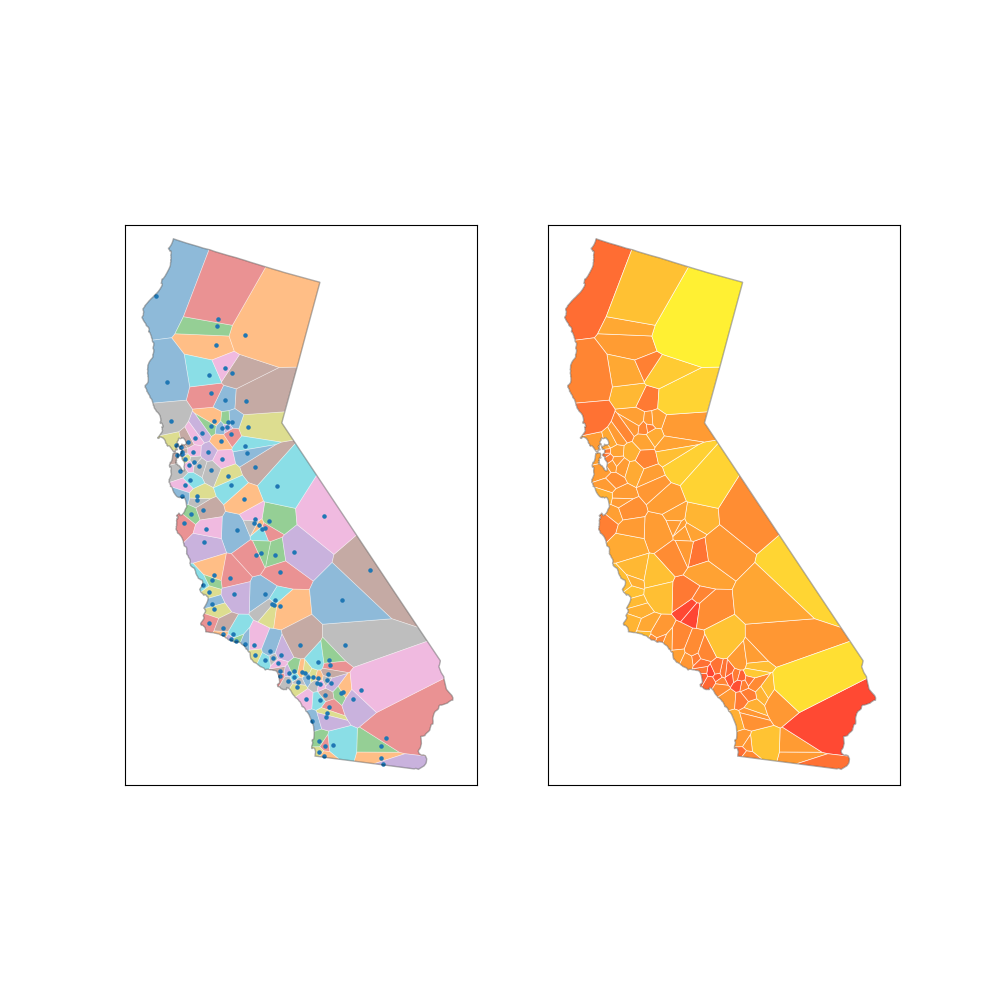

In [11]:
cali_plot()

In [53]:
A, L = get_L(165, edges)

In [54]:
lam, U = np.linalg.eigh(L)

(0.0, 3.0)

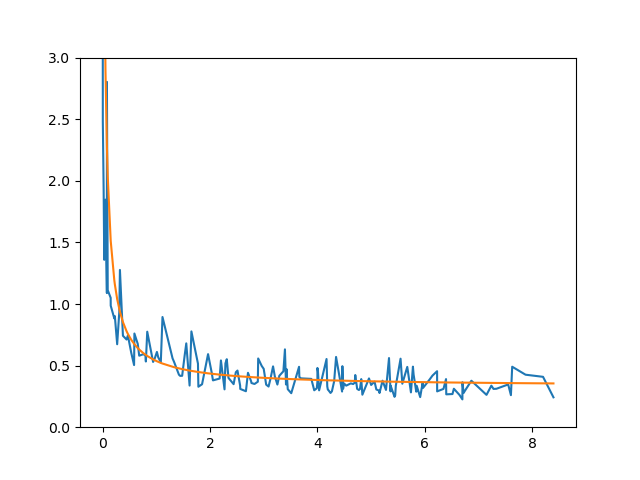

In [112]:
plt.figure()

spectral_std = (U.T @ data.values.T).std(1)

plt.plot(lam, spectral_std)

plt.plot(lam, 0.33 +  (spectral_std.max() - 0.33) / (35 * lam + 1))


plt.ylim(0, 3)